# Model Optimization of LOPE T1 Classifier V6

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np


In [3]:
from src.utils.data_loader import get_train_validation_input
from src.utils.data_loader import load_configuration_yaml
from src.utils.data_loader import save_predictor

In [4]:
from src.utils.model_optimizer.optimizer import get_best_params_cv
from src.utils.model_optimizer.optimizer import get_f1_score_loo
from src.utils.model_optimizer.optimizer import get_f1_score_cfv
from src.utils.model_optimizer.optimizer import get_f1_score_oss
from src.utils.model_optimizer.optimizer import get_model_opotimal
from src.utils.model_optimizer.optimizer import get_f1_data
from src.utils.model_optimizer.optimizer import get_prediction_loo
from src.utils.model_optimizer.optimizer import get_metrics_splits_ic
from src.utils.model_optimizer.evaluator import calculate_metrics
from src.utils.model_optimizer.evaluator import print_confusion_matrix

In [5]:
from src.utils.modelling_plots.modelplots import model_evaluation_plots
from src.utils.modelling_plots.modelplots import auc_plot_test_val
from src.utils.modelling_plots.modelplots import auc_plot_loo_val

In [6]:
from sklearn.svm import SVC

from sklearn.linear_model import  Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from tabpfn import TabPFNClassifier

### Globals

In [7]:
type_PE = "LOPE"
time = "T1"
DATASET_NAME = "lope_t1"
FOLDER_SAVE = "/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/final_model_v6/"
PATH_INPUT = "/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/LOPE_T1/"
path_cm = PATH_INPUT + "input_model_lope_ctr_t1_v6_19g_141024.csv"


In [8]:
CONFIG_PATH = "../../../config/model_optimizer/"

In [9]:
svm_config_file = CONFIG_PATH + "svc_config_parameters.yml"
lasso_config_file = CONFIG_PATH + "lasso_config_parameters.yml"
elasticnet_config_file = CONFIG_PATH + "elasticnet_config_parameters.yml"
xgb_config_file = CONFIG_PATH + "xgb_config_parameters.yml"
rf_config_file = CONFIG_PATH + "rf_config_parameters.yml"

### Input Data Loading

In [10]:
# Loading dicovery and validation datasets
x_train, y_train, x_val, y_val = get_train_validation_input(
    path_file_input=path_cm,
)

In [11]:
# Exploration of Datasets
shape_discovery = x_train.shape
shape_validation = x_val.shape
print(f"Total number of samples  {shape_discovery[0]+shape_validation[0]}")
print(f"Number samples discovery {shape_discovery[0]}")
print(f"Number samples validation {shape_validation[0]}")

Total number of samples  118
Number samples discovery 81
Number samples validation 37


In [12]:
print(f"Number of CONTROL samples in training and validation datasets: {list(y_train).count(0)} | {list(y_val).count(0)}")
print(f"Number of {type_PE} samples in training and validation datasets: {list(y_train).count(1)} | {list(y_val).count(1)}")
print(f"Number of genes in training and validation datasets: {x_train.shape[1]} | {x_val.shape[1]}")

Number of CONTROL samples in training and validation datasets: 51 | 24
Number of LOPE samples in training and validation datasets: 30 | 13
Number of genes in training and validation datasets: 19 | 19


In [13]:
NUMBER_GENES = x_train.shape[1]

In [14]:
train_proportions = round(100*(list(y_train)).count(1)/len(y_train), 2)
val_proportions = round(100*(list(y_val)).count(1)/len(y_val), 2)

print(f"Proportion of {type_PE} in discovey dataset {train_proportions}%")
print(f"Proportion of {type_PE} in validation dataset {val_proportions}%")

Proportion of LOPE in discovey dataset 37.04%
Proportion of LOPE in validation dataset 35.14%


### Load Configuration Data

In [15]:
param_grid_svc = load_configuration_yaml(path_configuration_yaml=svm_config_file)
param_grid_lasso = load_configuration_yaml(path_configuration_yaml=lasso_config_file)
param_grid_elasticnet = load_configuration_yaml(path_configuration_yaml=elasticnet_config_file)
param_grid_xgb = load_configuration_yaml(path_configuration_yaml=xgb_config_file)
param_grid_rf = load_configuration_yaml(path_configuration_yaml=rf_config_file)

### Algorithm Optimization with Cross Fold Validation

In [16]:
alg_parameter_search = {"SVC": [SVC(), param_grid_svc],
                        "Lasso": [Lasso(), param_grid_lasso],
                        "ElasticNet": [ElasticNet(), param_grid_elasticnet],
                        "RandomForest": [RandomForestClassifier(), param_grid_rf],
                        "XGBoost": [XGBClassifier(), param_grid_xgb]
}

alg_best_parameters = {
    "TabPFNClassifier": None,
    "SVC": {},
    "Lasso": {},
    "ElasticNet": {},
    "RandomForest": {},
    "XGBoost": {},
}

In [17]:
for alg_name, alg in alg_parameter_search.items():
    best_parameters = get_best_params_cv(clf_algorithm=alg[0],
                                         parameters_search=alg[1],
                                         x_train=x_train,
                                         y_train=y_train,
                                         )
    alg_best_parameters[alg_name] = best_parameters

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+00, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+00, tolerance: 1.514e-03
  model = cd_fast.enet_coordinate_descent(
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

### Algorithm Evaluation with LOO, CFV and OSS

In [18]:
alg_metrics = {"TabPFNClassifier": TabPFNClassifier,
                "SVC": SVC,
                "Lasso": Lasso,
                "ElasticNet": ElasticNet,
                "RandomForest": RandomForestClassifier,
                "XGBoost": XGBClassifier
}

alg_probabilities = {
    "TabPFNClassifier": True,
    "SVC": True,
    "Lasso": False,
    "ElasticNet": False,
    "RandomForest": True,
    "XGBoost": True,
}

alg_f1_metrics = {
    "TabPFNClassifier": [0, 0, 0, 0],   # F1 LOO, CFV, OSS, VAL
    "SVC": [0, 0, 0, 0], # F1 LOO, CFV, OSS, VAL
    "Lasso": [0, 0, 0, 0],    # F1 LOO, CFV, OSS, VAL
    "ElasticNet": [0, 0, 0, 0],   # F1 LOO, CFV, OSS, VAL
    "RandomForest": [0, 0, 0, 0], # F1 LOO, CFV, OSS, VAL
    "XGBoost": [0, 0, 0, 0],  # F1 LOO, CFV, OSS, VAL
}


In [19]:
for alg_name, alg in alg_metrics.items():
    f1_loo = get_f1_score_loo(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_cfv = get_f1_score_cfv(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_oss = get_f1_score_oss(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    trained_clf, trained_thr = get_model_opotimal(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_val = get_f1_data(trained_clf,
                         trained_thr,
                         x_val, y_val,
                         alg_probabilities[alg_name])
    alg_f1_metrics[alg_name] = [round(100*f1_loo),
                                round(100*f1_cfv),
                                round(100*f1_oss), 
                                round(100*f1_val)]
    
    

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on

In [20]:
# Result prints 
for alg_name, f1_metrics in alg_f1_metrics.items():
    print(f"{alg_name}: F1 LOO {f1_metrics[0]} | F1 CFV {f1_metrics[1]}  | F1 OSS {f1_metrics[2]} ")

TabPFNClassifier: F1 LOO 65 | F1 CFV 63  | F1 OSS 57 
SVC: F1 LOO 66 | F1 CFV 64  | F1 OSS 67 
Lasso: F1 LOO 65 | F1 CFV 63  | F1 OSS 40 
ElasticNet: F1 LOO 71 | F1 CFV 62  | F1 OSS 40 
RandomForest: F1 LOO 58 | F1 CFV 66  | F1 OSS 57 
XGBoost: F1 LOO 52 | F1 CFV 53  | F1 OSS 20 


### Visualization of Model Optimization

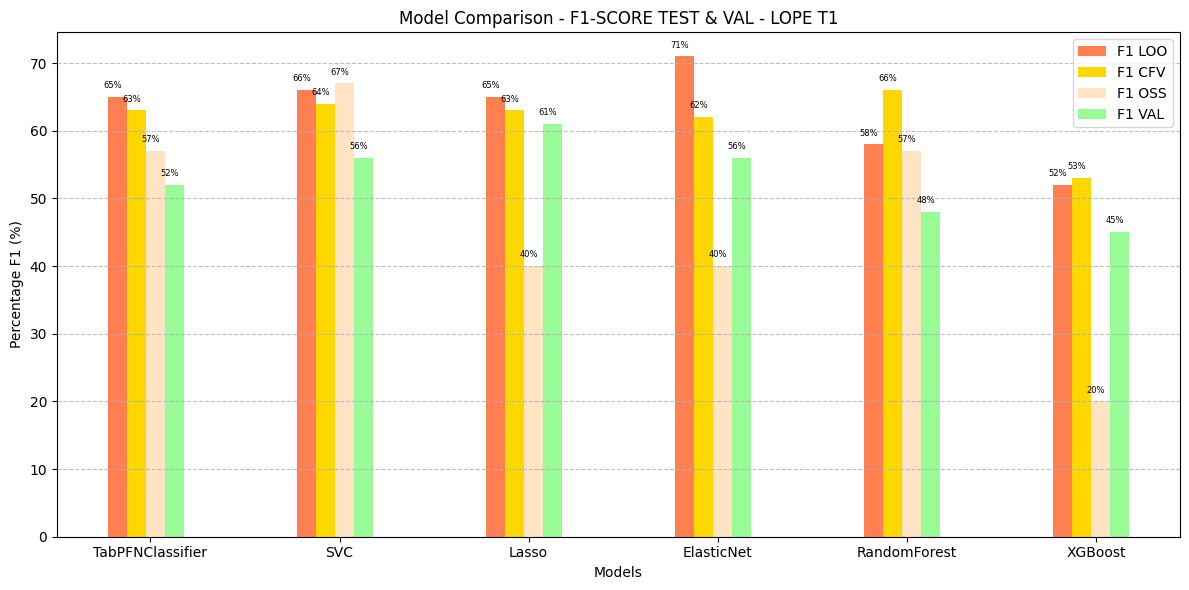

In [21]:
model_evaluation_plots(alg_f1_metrics, "LOPE T1")

### Final Model training

In [30]:
chosen_alg = "SVC"

In [31]:
alg_best_parameters[chosen_alg] = {'C': 1,
                                    'class_weight': None,
                                    'degree': 3,
                                    'gamma': 'scale',
                                    'kernel': 'rbf',
                                    'probability': True,
                                    'random_state': 42}

In [32]:
y_pred_loo, test_scores_loo, trained_thr = get_prediction_loo(
    alg_metrics[chosen_alg],
    alg_best_parameters[chosen_alg],
    x_train,
    y_train,
    True)
test_metrics_loo = get_metrics_splits_ic(y_train, np.array(y_pred_loo))

In [33]:
trained_clf, trained_thr = get_model_opotimal(clf_algorithm=alg_metrics[chosen_alg],
                                              params_algorithm=alg_best_parameters[chosen_alg],
                                              x_train=x_train,
                                              y_train=y_train,
                                              bool_probabilities=alg_probabilities[chosen_alg])

In [34]:
val_probs = trained_clf.predict_proba(x_val)[:,1]
val_metrics = calculate_metrics(np.array(y_val), val_probs, trained_thr)

In [35]:
print("#### LEAVE ONE OUT METRICS ####")
for metric, value in test_metrics_loo.items():
    print(f"\t{metric}: {value[0]} +/- {value[1]}")

print("#### LEAVE ONE OUT CM ####")
print_confusion_matrix(y_train, test_scores_loo, trained_thr)

#### LEAVE ONE OUT METRICS ####
	Accuracy: 72 +/- 13.32
	Recall: 73 +/- 15.6
	F1_Score: 64 +/- 18.7
	AUC: 71 +/- 13.16
	Specificity: 82 +/- 11.0
	Precision: 58 +/- 20.98
	PPV: 73 +/- 15.6
	NPV: 69 +/- 14.84
	FDR: 27 +/- 15.6
#### LEAVE ONE OUT CM ####
TN: 31
FP: 20
FN: 7
TP: 23


In [36]:
print("#### VALIDATION METRICS ####")
for metric, value in val_metrics.items():
    print(f"\t{metric}: {value}")

print("#### VALIDATION CM ####")
print_confusion_matrix(y_val, val_probs, trained_thr)

#### VALIDATION METRICS ####
	Accuracy: 68
	Recall: 69
	F1_Score: 60
	AUC: 68
	Specificity: 80
	Precision: 53
	PPV: 69
	NPV: 67
	FDR: 31
#### VALIDATION CM ####
TN: 16
FP: 8
FN: 4
TP: 9


In [37]:
y_val_list = list(y_val)
y_disc = list(y_train)
print(f"TOTAL DISCOVERY {len(y_disc)}, CTR {y_disc.count(0)}, EOPE {y_disc.count(1)}")
print(f"TOTAL VAL {len(y_val_list)}, CTR {y_val_list.count(0)}, EOPE {y_val_list.count(1)}")

TOTAL DISCOVERY 81, CTR 51, EOPE 30
TOTAL VAL 37, CTR 24, EOPE 13


### AUC Final Model

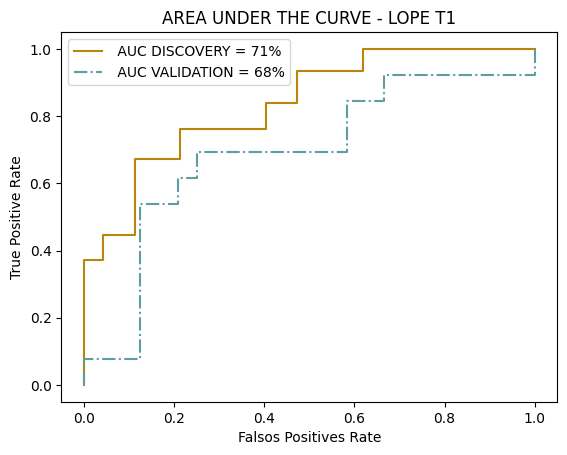

In [38]:
auc_plot_loo_val(y_test=y_train,
                 y_test_scores=test_scores_loo,
                 y_val=y_val,
                 y_val_scores=val_probs,
                 dataset_name="LOPE T1",
                 auc_test=test_metrics_loo["AUC"][0],
                 auc_val=val_metrics["AUC"],
                 num_splits=2)

### Saving trained model

In [31]:
save_predictor(trained_clf=trained_clf,
               trained_thr=trained_thr,
               path_folder_save=FOLDER_SAVE,
               num_variables=NUMBER_GENES,
               dataset_name=DATASET_NAME)

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/src/utils/data_loader.py:68: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/final_model_v6//lope_t1_19_SVC_optimal_102924.sav'>
  pickle.dump(trained_clf, open(path_file_name, 'wb'))
